In [1]:
import scanpy as sc
import pandas as pd
import infercnvpy as cnv
import numpy as np 

In [2]:
import sys
sys.path.append("/home/augusta/SSS_mount/insituCNV/InSituCNV/modules")
sys.path.append("/home/augusta/SSS_mount/insituCNV/InSituCNV")
import infercnv_pipeline as ip
import insitucnv as icv

# CosMx CNV inference

### Read in dataset
___

In [8]:
sid = '221'

In [9]:
adata = sc.read(f"/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/round2/{sid}/adata_{sid}_processed_1.h5ad")
# adata = sc.read(f"/home/augusta/insituCNV/adata_{sid}_processed_1.h5ad")

In [6]:
read_depth = adata.layers['raw'].sum(axis=1)

average_read_depth = read_depth.mean()
average_read_depth

973.1890595147872

In [10]:
adata

AnnData object with n_obs × n_vars = 347023 × 18545
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

In [11]:
common_genes_df = pd.read_csv("snPATHO-seq/221_common_genes.csv")
common_genes_df.head()

,common_genes
0,PHYHIPL
1,MAPKAPK2
2,AGFG2
3,ELMO2
4,ACOT7


In [12]:
adata = adata[:, adata.var_names.isin(common_genes_df['common_genes'])].copy()

In [13]:
adata

AnnData object with n_obs × n_vars = 347023 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

### Subset the data if too big
_________

In [8]:
# Get a random subset of 50% of the cell indices
# subset_indices = np.random.choice(adata.n_obs, size=int(0.5 * adata.n_obs), replace=False)

# Subset the AnnData object
# adata = adata[subset_indices, :].copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 333540 × 18555
    obs: 'Unnamed: 0', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'version', 'Run_name', 'Run_Tissue_name', 'tissue', 'Panel', 'assay_type', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'sid', 'add_sub', 'ROI_status', 'healthy_ROI', 'n_counts'
    var: 'Unnamed: 0', 'start', 'end', 'width', 'names', 'gene_id', 'symbol', 'ensg', 'chromosome', 'features_all', 'features_epi'
    uns: 'ROI_status_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'
    layers: 'M', 'lognorm', 'raw'
    obsp: 'connectivities', 'distances'

### Run CNV inference and epithelial clustering
_______

In [14]:
# Select the smoothed count data
adata.X = adata.layers['M'].copy()
cnv.tl.infercnv(adata, 
                window_size =100,
                reference_key = 'ROI_status',
                reference_cat = ['REF'],
                chunksize = 1000)

  0%|          | 0/348 [00:00<?, ?it/s]

In [15]:
adata

AnnData object with n_obs × n_vars = 347023 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

In [16]:
adata.write("CosMx_221_common_genes_CNV.h5ad", compression = 'gzip')

In [3]:
adata = sc.read("CosMx_221_common_genes_CNV.h5ad")

In [4]:
# Select only the epithelial cells
adata_epi = adata[adata.obs.add_sub == 'epi'].copy()

In [5]:
adata_epi

AnnData object with n_obs × n_vars = 235598 × 14044
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'Dash', 'ISH.concentration', 'Panel', 'Run_Tissue_name', 'Run_name', 'assay_type', 'dualfiles', 'tissue', 'version', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'median_RNA', 'RNA_quantile_0.75', 'RNA_quantile_0.8', 'RNA_quantile_0.85', 'RNA_quantile_0.9', 'RNA_quantile_0.95', 'RNA_quantile_0.99', 'nCount_RNA', 'nFeature_RNA', 'median_negprobes', 'negprobes_quantile_0.75', 'negprobes_quantile_0.8', 'negprobes_quantile_0.85', 'negprobes_quantile_0.9', 'negprobes_quantile_0.95', 'negprobes_quantile_0.99', 'nCount_negprobes', 'nFeature_negprobes', 'median_falsecode', 'falsecode_quantile_0.75', 'falsecode_quantile_0.8', 'falsecode_quantil

In [6]:
cnv.tl.pca(adata_epi)
cnv.pp.neighbors(adata_epi)

In [ ]:
resolutions=[0.1, 0.3, 0.5]
    
for res in resolutions:

    # Cluster only the epithelial cells
    print('leiden res', res)
    key_added=f'epi_cnv_leiden_res{res}'


    cnv.tl.leiden(adata, resolution = res, key_added=key_added)

    # Add the epithelial clustering back to the whole CosMx dataset
    adata.obs[key_added] = np.nan
    adata.obs.loc[adata_epi.obs_names, key_added] = adata_epi.obs[key_added]

    # Plot CNV heatmap with dentrogram and vmin and vmax for comparison.
    print('heatmap')
    adata.obs[key_added].fillna("non-epi", inplace=True)
    save_heatmap = f"_CosMx_{sid}_common_groupby-{key_added}.png"
    cnv.pl.chromosome_heatmap(adata, groupby=key_added, dendrogram=True, save=save_heatmap, vmin=-.4, vmax=0.4) 

    sc.pl.spatial(adata, color=key_added, spot_size=100)

In [43]:
# For UMAP illustrations and CNV scores
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.umap(adata)

### Plot and save figures
_________

In [29]:
type(adata.obs['epi_cnv_leiden_res0.1'])

pandas.core.series.Series

In [30]:
adata.obs['epi_cnv_leiden_res0.1']

c_2_1_2             0.0
c_2_1_5             0.0
c_2_1_7             0.0
c_2_1_8             0.0
c_2_1_9             0.0
                 ...   
c_2_209_1539        0.0
c_2_209_1541        0.0
c_2_209_1542    non-epi
c_2_209_1543        1.0
c_2_209_1544        0.0
Name: epi_cnv_leiden_res0.1, Length: 347023, dtype: category
Categories (8, object): ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', 'non-epi']

In [37]:
adata.uns['epi_cnv_leiden_res0.1_colors']

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f']

In [38]:
adata.uns['epi_cnv_leiden_res0.1_colors'] = ['#1f77b4', 
                                             '#2ca02c', # Changing place with cluster 1 and 2
                                             '#ff7f0e',
                                             '#d62728',
                                             '#9467bd',
                                             '#8c564b',
                                             '#e377c2',
                                             '#7f7f7f']

... storing 'epi_cnv_leiden_res0.1' as categorical


categories: 0.0, 1.0, 2.0, etc.
var_group_labels: chr1, chr2, chr3, etc.


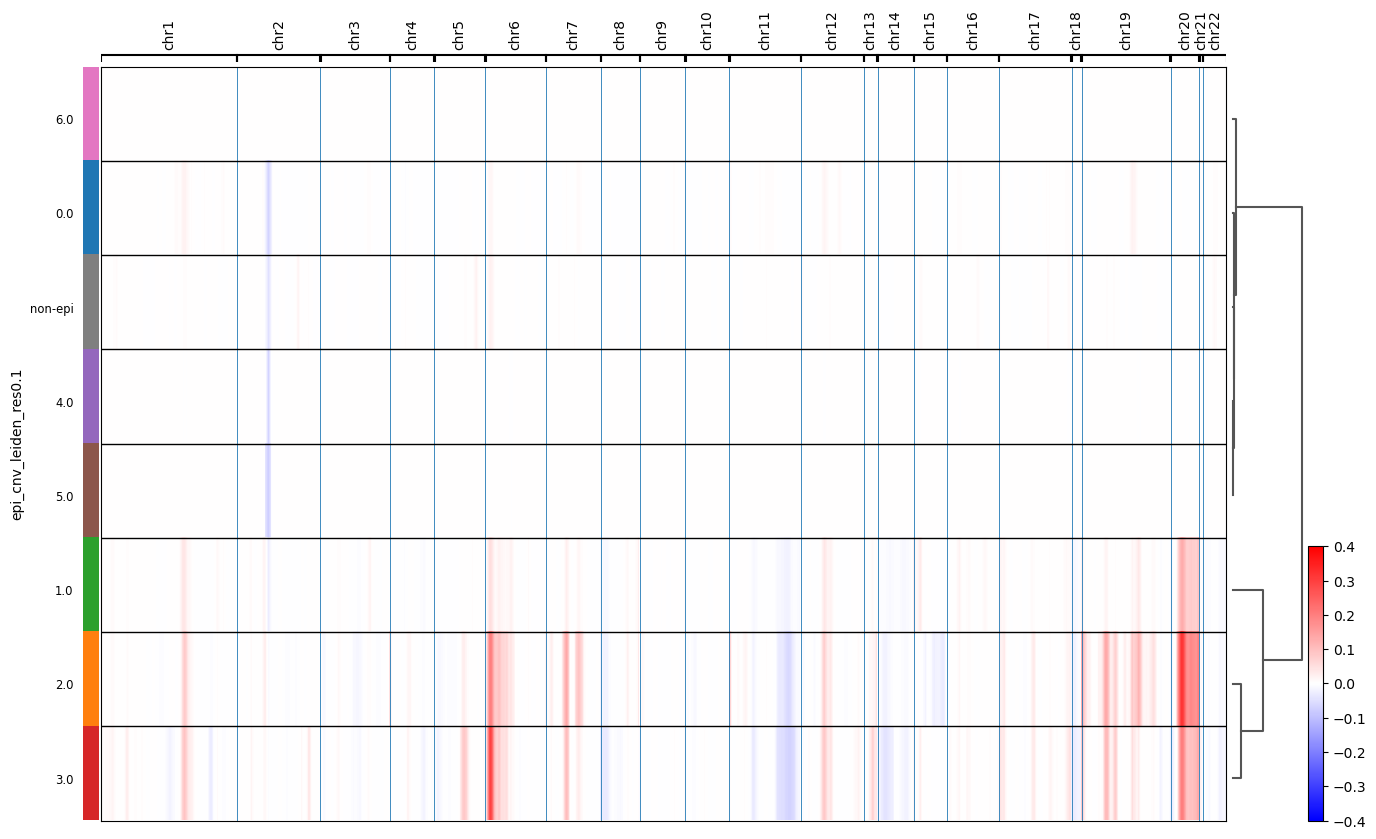

In [42]:
sid ='221'
groupby='epi_cnv_leiden_res0.1'
save_heatmap = f"_summary_CosMx_{sid}_common_groupby-{groupby}.pdf"
# save_heatmap = None
cnv.pl.chromosome_heatmap_summary(adata, groupby=groupby, dendrogram=True, save=save_heatmap, vmin=-.4, vmax=0.4)

categories: 0.0, 1.0, 2.0, etc.
var_group_labels: chr1, chr2, chr3, etc.


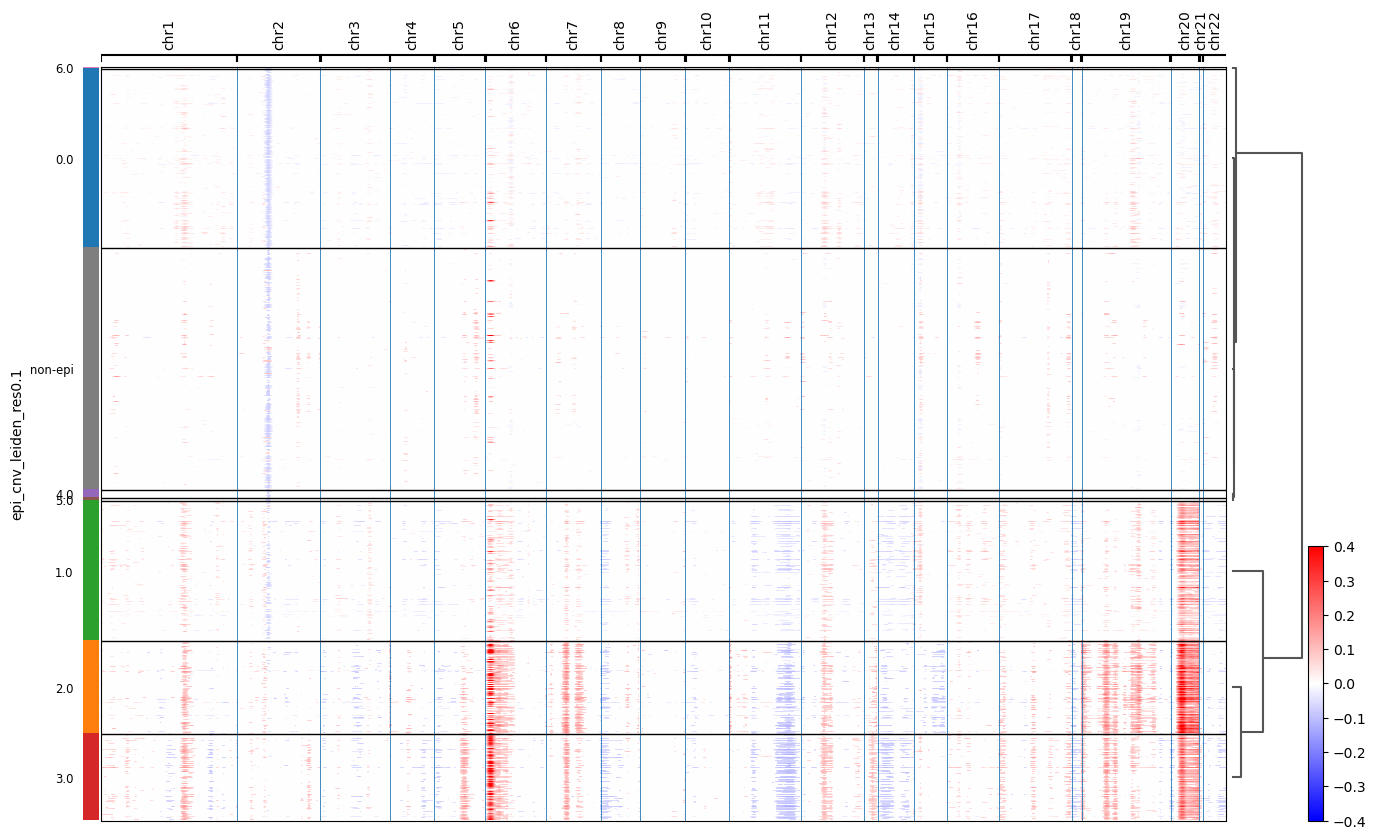

In [41]:
sid ='221'
groupby='epi_cnv_leiden_res0.1'
save_heatmap = f"_CosMx_{sid}_common_groupby-{groupby}.pdf"
# save_heatmap = None
cnv.pl.chromosome_heatmap(adata, groupby=groupby, dendrogram=True, save=save_heatmap, vmin=-.4, vmax=0.4)

In [ ]:
color='add_sub'
save=f'_CosMx_{sid}_groupby-{color}.pdf'
# save=None
sc.pl.spatial(adata, color=color, spot_size=100, save=save)

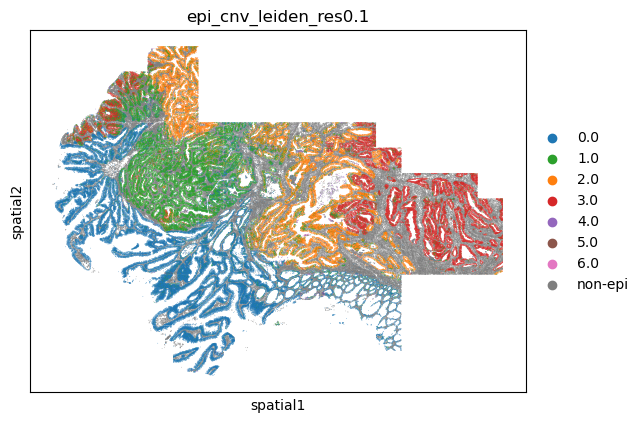

In [39]:
color='epi_cnv_leiden_res0.1'
save=f'_CosMx_{sid}_common_groupby-{color}.pdf'
# save=None
sc.pl.spatial(adata, color=color, spot_size=100, save=save)

In [44]:
groupby='epi_cnv_leiden_res0.1'
key_added='epi_cnv_score_res0.1'
cnv.tl.cnv_score(adata, groupby=groupby, key_added=key_added)

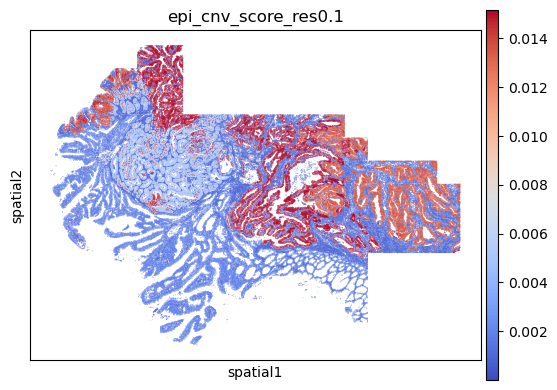

In [46]:
color='epi_cnv_score_res0.1'
save = f"_CosMx_{sid}_common_groupby-{color}.pdf"
sc.pl.spatial(adata, color=color, cmap = 'coolwarm', spot_size=100, save=save)

### Save new adata object with CNV information
______

In [47]:
adata.write(f"/home/augusta/insituCNV/CosMx_{sid}_common_CNVinf.h5ad", compression = 'gzip')